# Example Notebook - Trades

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

print(f"Current working directory: {os.getcwd()}")
print(f"Source code is in system path @ {sys.path[0]}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import joblib

Current working directory: /Users/joshgowdy/GitHub/GB-energy-trading/example_notebooks
Source code is in system path @ /Users/joshgowdy/GitHub/GB-energy-trading/code


In [3]:
from code_utils.training import plot_model_validation, plot_roc_curve

## Load Trained Model and Processed Data

In [134]:
# load model
model = joblib.load('../models/auction_ensemble_model.pkl')
results = pd.read_csv('../models/auction_ensemble_results.csv')
    
# load training, vallidation and holdout data
X_train = pd.read_csv('../data/processed/X_train.csv', index_col=0)
y_train = pd.read_csv('../data/processed/y_train.csv', index_col=0)
X_valid = pd.read_csv('../data/processed/X_valid.csv', index_col=0)
y_valid = pd.read_csv('../data/processed/y_valid.csv', index_col=0)
X_holdout = pd.read_csv('../data/processed/X_holdout.csv', index_col=0)
y_holdout = pd.read_csv('../data/processed/y_holdout.csv', index_col=0)

# load auction data
auction_data = pd.read_csv('../data/processed/auction_data.csv', index_col=0)
auction_data=auction_data[['price_first_auction', 'price_second_auction', 'auction_price_spread',
       'auction_spread_dir']]
auction_data_valid=auction_data[auction_data.index.isin(X_valid.index)]
auction_data_holdout=auction_data[auction_data.index.isin(X_holdout.index)]

In [135]:
# check accuracy on training, validation and holdout data
# use the best threshold from the results
best_threshold = results.loc[0,'optimum_prediction_threshold']
y_train_proba = model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= best_threshold).astype(int)
train_accuracy = accuracy_score(y_train, y_train_pred)
y_valid_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_proba >= best_threshold).astype(int)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)  
y_holdout_proba = model.predict_proba(X_holdout)[:, 1]
y_holdout_pred = (y_holdout_proba >= best_threshold).astype(int)
holdout_accuracy = accuracy_score(y_holdout, y_holdout_pred)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Validation accuracy: {valid_accuracy:.4f}")
print(f"Holdout accuracy: {holdout_accuracy:.4f}")

Training accuracy: 0.6617
Validation accuracy: 0.6203
Holdout accuracy: 0.6223


In [136]:
# combine valid and holdout sets

X_test=pd.concat([X_valid, X_holdout], axis=0)
y_test=pd.concat([y_valid, y_holdout], axis=0)
y_test_proba=model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba>=best_threshold).astype(int)
test_accuracy=accuracy_score(y_test, y_test_pred)
print(f"Test (valid + holdout) accuracy: {test_accuracy:.4f}")
auction_data_test=auction_data[auction_data.index.isin(X_test.index)]

Test (valid + holdout) accuracy: 0.6214


In [137]:
# combine all sets

X=pd.concat([X_train, X_valid, X_holdout], axis=0)
y=pd.concat([y_train, y_valid, y_holdout], axis=0)
y_proba=model.predict_proba(X)[:, 1]
y_pred = (y_proba>=best_threshold).astype(int)
overall_accuracy=accuracy_score(y, y_pred)
print(f"Overall accuracy: {overall_accuracy:.4f}")

Overall accuracy: 0.6540


In [138]:
results

,model_1,model_2,optimum_weight_model_1,optimum_prediction_threshold,validation_start_date,validation_accuracy,holdout_start_date,holdout_accuracy
0,logistic_regression,xgboost,0.473684,0.462312,2022-07-16 03:00:00,0.620329,2022-08-13,0.622312


Toggle whether we evaulate strategies on entire dataset or just validation and holdout data (excluding data used during training)

In [89]:
test_on_all_data=False

# Day Ahead Market Objective and Constraints

We carry out trades on both of the day ahead auctions. With possible exposure to the system price of the balancing mechanism if our position is imbalanced. We are an unphysical trader with no energy backing.

Since we are an unphysical trader and are simply performing price arbitrage. We are not so much interested in the price of energy to sell or buy but rather the price spread between markets. We are hence free to submit bids at way above market rate to ensure they are acccepted at the clearing price. Similarly we can submit offers way below the clearing price to ensure the offer is accepted and we do not need to worry about covering our marginal costs of producing the energy.

We simply need to guess the direction of the price spread. Assuming that all our bids and offers are accepted. So we are completely shielded from the balancing mechanism.

EPEX SPOT one of the two power exchanges in GB uses a flat fee per trade

In [90]:
fee = 5 # GBP auction fee per trade, purely illuistrative

## Baseline Strategy

We define a strategy that uses no modeling at all. It makes trades based on copying the price movements on the previous day onto the next.

We build an order book of sorts.

In [103]:
if test_on_all_data == True:
    order_book = auction_data.copy()
else:
    order_book=auction_data_test.copy()
    
order_book['auction_spread_dir_lag24']= order_book['auction_spread_dir'].shift(24)
order_book['trade']=np.where(order_book['auction_spread_dir_lag24']==1, 'long', np.where(order_book['auction_spread_dir_lag24']==0, 'short', 'hold'))
order_book

,price_first_auction,price_second_auction,auction_price_spread,auction_spread_dir,auction_spread_dir_lag24,trade
date,,,,,,
2022-07-16 03:00:00,205.6,198.82,-6.78,0,NaN,hold
2022-07-16 04:00:00,202.0,194.80,-7.20,0,NaN,hold
2022-07-16 05:00:00,198.2,192.90,-5.30,0,NaN,hold
2022-07-16 06:00:00,197.0,196.76,-0.24,0,NaN,hold
2022-07-16 07:00:00,202.0,186.65,-15.35,0,NaN,hold
...,...,...,...,...,...,...
2022-09-12 19:00:00,465.6,437.60,-28.00,0,1.0,long
2022-09-12 20:00:00,418.0,391.45,-26.55,0,1.0,long
2022-09-12 21:00:00,358.7,342.29,-16.41,0,1.0,long


fixed volume for each trade, and fixed fee also

In [104]:
vol = 10 # MWh volume per trade, purely illustrative

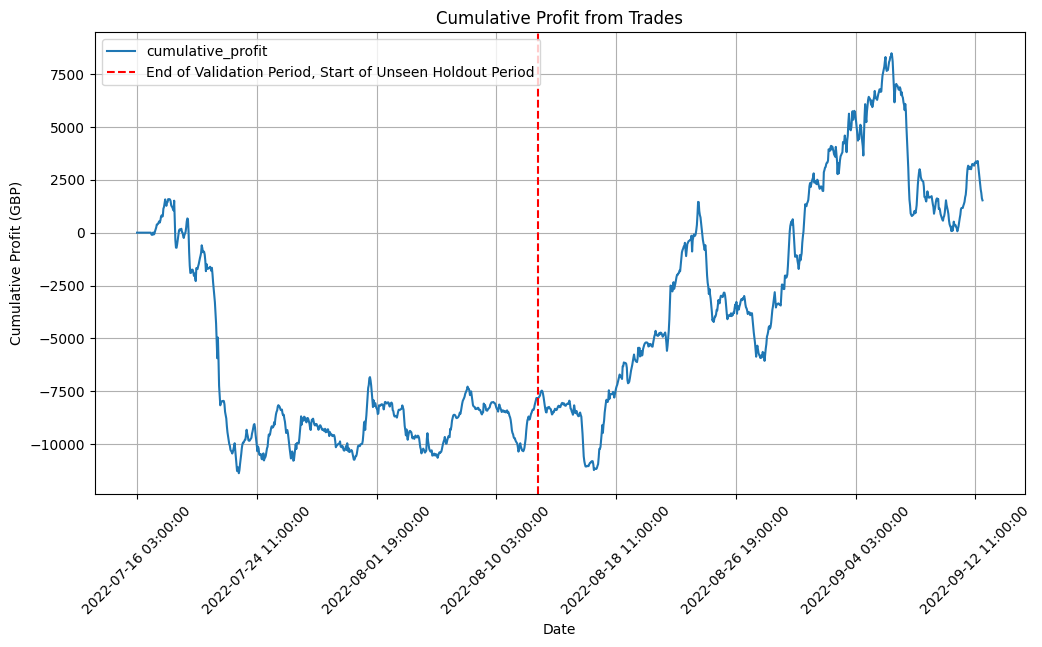

In [105]:
order_book['profit']= np.where(order_book['trade']=='long',
                                    (order_book['price_second_auction'] - order_book['price_first_auction']) * vol - fee,
                                    np.where(order_book['trade']=='short',
                                             (order_book['price_first_auction'] - order_book['price_second_auction']) * vol - fee,
                                             0))
order_book['cumulative_profit'] = order_book['profit'].cumsum()
order_book['cumulative_profit'].plot(figsize=(12, 6), title='Cumulative Profit from Trades', grid=True)
# add vertical line at the end of the validation period
plt.axvline(x=(order_book.shape[0]-X_holdout.shape[0]), color='red', linestyle='--', label='End of Validation Period, Start of Unseen Holdout Period')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Cumulative Profit (GBP)')
plt.legend()
plt.show()

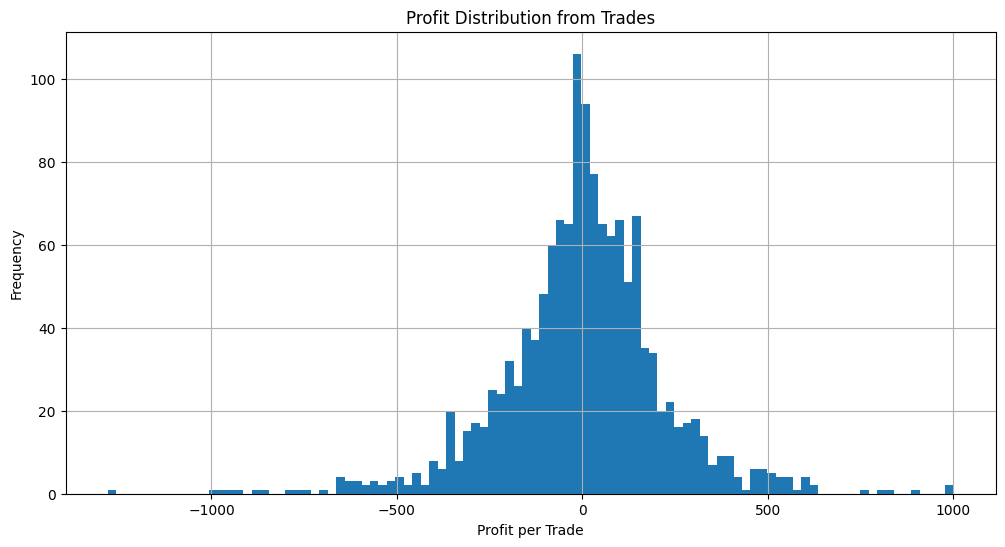

In [106]:
ax = order_book[order_book['profit']!=0]['profit'].hist(bins=100, figsize=(12, 6), grid=True)
plt.title('Profit Distribution from Trades')
plt.xlabel('Profit per Trade')
plt.ylabel('Frequency')
plt.show()

We calculate the ROI. The invested cash is the cash at work for each trade i.e. the trade volume multiplied by the first auction price (as a reference price)

In [108]:
total_invested_cash = (vol * order_book['price_first_auction'])[order_book['trade'] != 'hold'].sum()
total_profit = order_book['cumulative_profit'].iloc[-1]
roi= 100*total_profit / total_invested_cash
time_held=order_book.shape[0]/(24*365)
annualised_roi=((1+roi/100)**(1/time_held)-1)*100

print(f"Invested Cash: {total_invested_cash:.2f} GBP")
print(f"Total Profit: {total_profit:.2f} GBP")
print(f"Return on Investment (ROI): {roi:.4f} %")
print(f"Time Held in years: {time_held}")
print(f"Annualised ROI:{annualised_roi} %")

Invested Cash: 4573678.50 GBP
Total Profit: 1529.40 GBP
Return on Investment (ROI): 0.0334 %
Time Held in years: 0.1613013698630137
Annualised ROI:0.2074889449089401 %


## Main Strategy

We set up a strategy which trades according to the model predicitions/class probabilities.

In [110]:
if test_on_all_data==True:
    order_book = auction_data.copy()
    order_book["y_proba"]=y_proba
else:
    order_book=auction_data_test.copy()
    order_book["y_proba"]=y_test_proba

I.e. long when model probabilities exceeds a upper threshold and short when the model is below another threshold. Hold otherewise.

In [111]:
threshold_delta = 0.15 # adjust this value to set the threshold range
upper_threshold=best_threshold + threshold_delta
lower_threshold=best_threshold - threshold_delta

order_book['trade'] = np.where(order_book["y_proba"] > upper_threshold, 'long', np.where(order_book["y_proba"] < lower_threshold,'short', 'hold'))

We can size positions also based on the model probabilities i.e. its confidence in the trade. For long positions we look for high probabilities close to 1, so we can size positions mulriplying the max_vol traded with the prob. For short positions we want the opposite so we should size positions with a factor (1-prob), so a prediction close to 0 is a strong signal to short with a large position.

We include a sizing_exponent which controls the sensitivity of the sizing factor i.e. how stringent we make trades. E.g. for a exponent of 2, when the model probability decreases by factor of 2 the sizing decreases by factor of 4.

In [112]:
max_vol = 10 # Maximum volume MWh per trade, purely illustrative

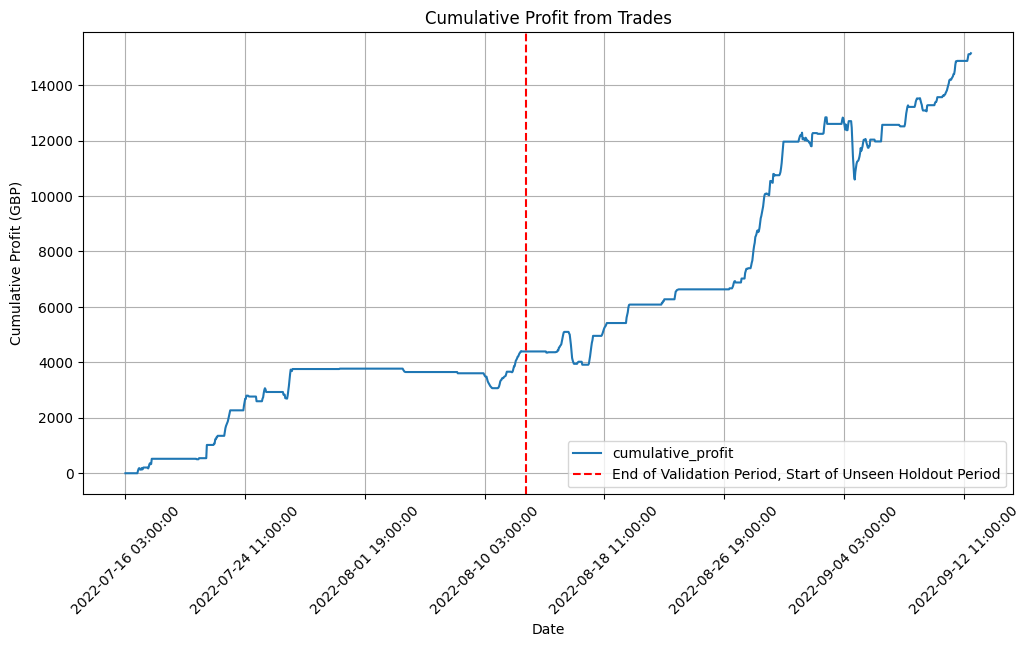

In [113]:
sizing_exponent = 2 # adjust this to control the sensitivity of the position sizing based on the model class probabilities

order_book['position_size'] = np.where(
    order_book['trade'] == 'long',
    (order_book["y_proba"] ** sizing_exponent) * max_vol,
    np.where(
        order_book['trade'] == 'short',
        ((1 - order_book["y_proba"]) ** sizing_exponent) * max_vol,
        0
    )
)

order_book['profit'] = np.where(
    order_book['trade'] == 'long',
    (order_book['price_second_auction'] - order_book['price_first_auction']) * order_book['position_size']-fee,
    np.where(
        order_book['trade'] == 'short',
        (order_book['price_first_auction'] - order_book['price_second_auction']) * order_book['position_size']-fee,
        0
    )
)

order_book['cumulative_profit'] = order_book['profit'].cumsum()
order_book['cumulative_profit'].plot(figsize=(12, 6), title='Cumulative Profit from Trades', grid=True)
# add vertical line at the end of the validation period
plt.axvline(x=(order_book.shape[0]-X_holdout.shape[0]), color='red', linestyle='--', label='End of Validation Period, Start of Unseen Holdout Period')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Cumulative Profit (GBP)')
plt.legend()
plt.show()


We calculate the ROI. The invested cash is the cash 'at work'/'at risk' for each trade i.e. the trade volume multiplied by the first auction price (as a reference price)

In [114]:
total_invested_cash = (order_book['position_size'] * order_book['price_first_auction'])[order_book['trade'] != 'hold'].sum()
total_profit = order_book['cumulative_profit'].iloc[-1]
roi= 100*total_profit / total_invested_cash
time_held=order_book.shape[0]/(24*365)
annualised_roi=((1+roi/100)**(1/time_held)-1)*100

print(f"Invested Cash: {total_invested_cash:.2f} GBP")
print(f"Total Profit: {total_profit:.2f} GBP")
print(f"Return on Investment (ROI): {roi:.4f} %")
print(f"Time Held in years: {time_held}")
print(f"Annualised ROI:{annualised_roi} %")

Invested Cash: 609666.32 GBP
Total Profit: 15151.89 GBP
Return on Investment (ROI): 2.4853 %
Time Held in years: 0.1613013698630137
Annualised ROI:16.43850797826003 %


In [147]:
        #find daily returns by resampling the hourly profit
profit_df = order_book['profit'].to_frame()
if not isinstance(profit_df.index, pd.DatetimeIndex):
    profit_df.index = pd.to_datetime(profit_df.index)
daily_returns = profit_df.resample('D').sum().dropna()

mean_return = daily_returns.mean()['profit']
std_return = daily_returns.std()['profit']

In [148]:
mean_return, std_return

(np.float64(256.81176123473534), np.float64(566.185780236175))

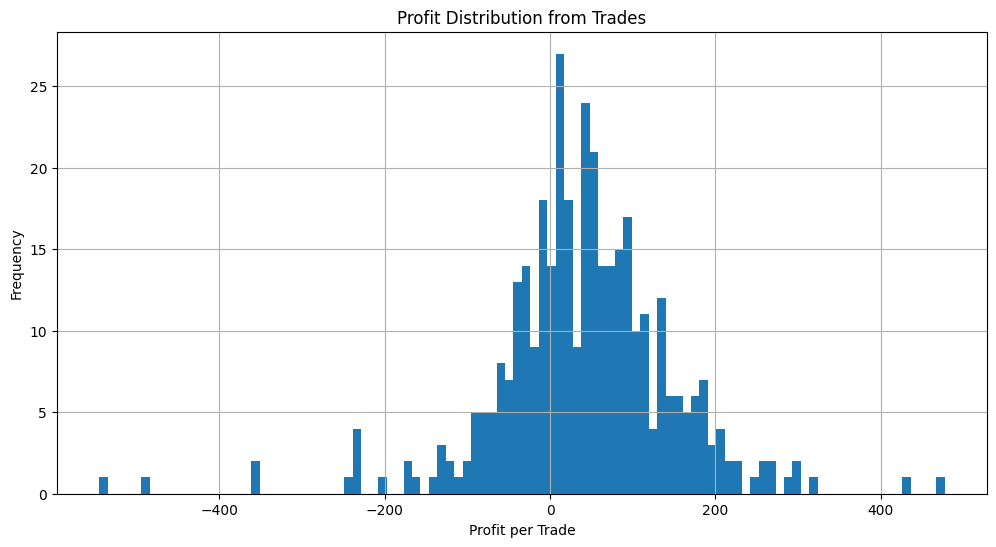

In [115]:
ax = order_book[order_book['profit']!=0]['profit'].hist(bins=100, figsize=(12, 6), grid=True)
plt.title('Profit Distribution from Trades')
plt.xlabel('Profit per Trade')
plt.ylabel('Frequency')
plt.show()